# GPPVAE demo

This notebook demonstrates the use of my GPPVAE implementation in with a slightly more complex configuration. The aim is to implement a mixed Gaussian prior VAE using a GPPVAE approach. This serves as a proof-of-concept for further development.

In [1]:
import os
import csv
import sys
import torch
import pickle
import gpytorch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch import optim
from torch.utils import data
from torchvision import transforms
from torch.nn import functional as F
from gpytorch.kernels import RBFKernel, ScaleKernel, AdditiveKernel

In [2]:
# we need to manually add the project directory to the path when using Jupyter notebooks
sys.path.append("/home/santeri/repos/HIT_VAE") # location on home computer
sys.path.append("/u/14/mentus1/unix/repos/HIT_VAE") # location on Aalto computers

In [3]:
from hit_vae.models import mnist_conv_vae
from hit_vae.models import losses
from hit_vae.utils import data_loading
from hit_vae.utils import plotting
from hit_vae.basic_kernels.constant_kernel import ConstantKernel
from hit_vae.basic_kernels.categorical_kernel import CategoricalKernel
from hit_vae.basic_kernels.input_warping_kernel import InputWarpingKernel

In [4]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print(f'using device: {device}')

using device: cuda


In [5]:
skip_training = True

## GPPVAE

We first build, train, and evaluate the GPPVAE model

### Loading the data

The beginning is the same as in the VAE demo

In [6]:
data_base_path = '../../data/mnist_gen_flip'
# csv which contains the IDs and labels for the training data
label_path = os.path.join(data_base_path, 'labels.csv')
label_df = pd.read_csv(label_path, index_col=0)
labels = torch.Tensor(label_df.values)
#labels = label_df.to_dict(orient='index')
# we also store all the labels in a separate list
#list_IDs = list(labels.keys())
list_IDs = range(len(labels))

In [7]:
# for expariments use 50% of the samples for testing and validation and 70% for training
test_ratio = 0.5

# transformations applied to samples
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
    ])

# we use the Dataset class defined in utils to store the data
training_set = data_loading.TensorLabelDataset(data_base_path, list_IDs, labels, transform=transform)

n_train = len(training_set)
#indices = list(labels.keys())
indices = np.arange(len(training_set))
#np.random.shuffle(indices) # we randomize the order of the samples

test_split = int(np.floor(test_ratio * n_train))
test_IDs, training_IDs = indices[:test_split], indices[test_split:]
#print(labels[training_IDs])

We define a custom sampler for loading test data in the same order each time

In [8]:
from torch.utils.data import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements sequentially, always in the same order.

    Arguments:
        data_source (Dataset): dataset to sample from
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return len(self.indices)

In [9]:
#from torch.utils.data import SubsetRandomSampler

# change the number of workers based on your CPU
loader_params = {'batch_size': 32, 'num_workers': 4}

training_sampler = data.SubsetRandomSampler(training_IDs)
#test_sampler = data.SubsetRandomSampler(test_IDs)

#training_sampler = SubsetSampler(training_IDs)
test_sampler = SubsetSampler(test_IDs)

# torch data loaders with parallelization for efficiency
training_loader = data.DataLoader(training_set, **loader_params, sampler=training_sampler)
test_loader = data.DataLoader(training_set, **loader_params, sampler=test_sampler)

In [10]:
# sanity check for the training data
image_sample, label_sample = iter(test_loader).next()
print(label_sample[1:10, 4].view(-1))

tensor([-9., -8., -7., -6., -5., -4., -3., -2., -1.])


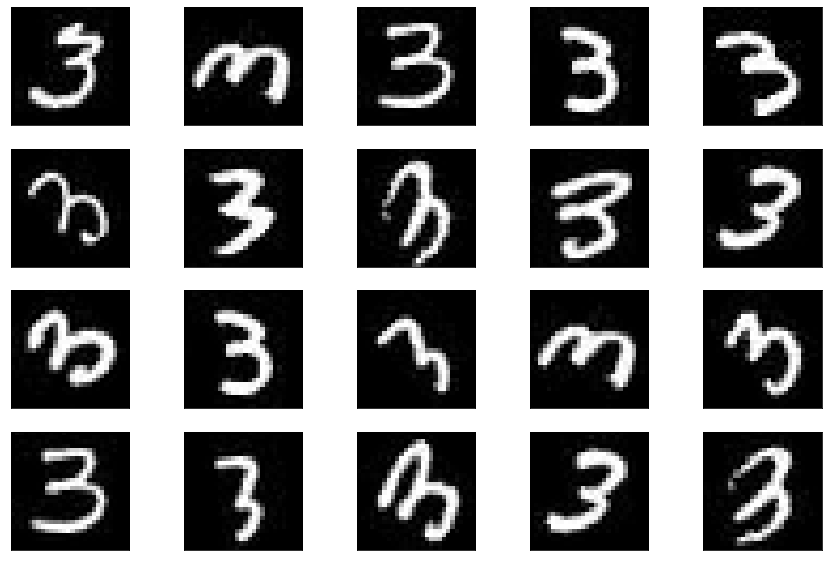

In [11]:
# visualize a set of samples as a check
#images, labels = iter(training_loader).next()
plotting.visualize_samples(iter(training_loader))

### Neural network

For this demo I use the same simple convolutional network model as in the VAE demo. The latent space is two dimensional for better interpretability of the results.

In [12]:
# initialize the model defined in the models module
ldim = 2
vae_model = mnist_conv_vae.DigitVae(ldim=ldim)
vae_model.to(device)

DigitVae(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc21): Linear(in_features=32, out_features=2, bias=True)
  (fc22): Linear(in_features=32, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=784, bias=True)
  (deconv1): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

The model is pretrained using a normal VAE prior, as was done by Casale et al. in their paper.

In [13]:
ckpt_name = 'basic_conv_vae_flip_MNIST.pt'
load_path = '../../trained_models'
vae_model.load_state_dict(torch.load(os.path.join(load_path, ckpt_name)))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [14]:
#vae_model.eval()

#recon_images, Z, logvar = vae_model(image_sample.to(device))
#print(Z)

### GP prior

In order to set a GP prior on the latent space, we use two identical gaussian process models, which are trained simultaneously with the neural network.

In [15]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, covar_module):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = covar_module
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [16]:
#covar_module = ScaleKernel(ConstantKernel(active_dims=0)) * CategoricalKernel(active_dims=0)
#covar_module = CategoricalKernel()#ScaleKernel(CategoricalKernel(active_dims=0))
#covar_module = ScaleKernel(RBFKernel(active_dims=0))
const_module = CategoricalKernel(active_dims=3) # * ScaleKernel(ConstantKernel(active_dims=4))
iw_module = ScaleKernel(InputWarpingKernel(active_dims=4)) * CategoricalKernel(active_dims=3)

covar_module = const_module + iw_module #rbf_module

In [17]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

In [18]:
training_labels = labels[training_IDs].to(device)
placeholder_targets = torch.zeros(len(training_labels)).view(-1)

print(training_labels.shape)
print(placeholder_targets.shape)

# initialize the GP models using sample data
gp_x = ExactGPModel(training_labels, placeholder_targets, likelihood, covar_module).to(device)
gp_y = ExactGPModel(training_labels, placeholder_targets, likelihood, covar_module).to(device)

torch.Size([300, 5])
torch.Size([300])


In [19]:
gp_x

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (quadrature): GaussHermiteQuadrature1D()
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): AdditiveKernel(
    (kernels): ModuleList(
      (0): CategoricalKernel()
      (1): ProductKernel(
        (kernels): ModuleList(
          (0): ScaleKernel(
            (base_kernel): InputWarpingKernel(
              (raw_lengthscale_constraint): Positive()
            )
            (raw_outputscale_constraint): Positive()
          )
          (1): CategoricalKernel()
        )
      )
    )
  )
)

### Training the model

In [20]:
vae_optimizer = optim.Adam(vae_model.parameters(), lr=0.0001)
gp_x_optimizer = optim.Adam([ {'params': gp_x.parameters()},], lr=0.01)
gp_y_optimizer = optim.Adam([ {'params': gp_y.parameters()},], lr=0.01)

training_labels = labels[training_IDs].to(device)

In [21]:
mll_x = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_x)
mll_y = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_y)

In [22]:
gp_x.train()
gp_y.train()
vae_model.train()

DigitVae(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc21): Linear(in_features=32, out_features=2, bias=True)
  (fc22): Linear(in_features=32, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=784, bias=True)
  (deconv1): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [23]:
def train(epoch):
    
    vae_optimizer.zero_grad()
    gp_x_optimizer.zero_grad()
    gp_y_optimizer.zero_grad()
    
    gp_weight = 10
    
    data = torch.tensor([]).to(device)
    raw = torch.tensor([]).to(device)
    Z = torch.tensor([]).to(device)
    logvars = torch.tensor([]).to(device)
    recon_data = torch.tensor([]).to(device)
    #labels_during_training = torch.tensor([]).to(device)
    
    # 1. encode, sample, reconstruct
    
    for batch_idx, (data_batch, labels) in enumerate(training_loader):
        
        data_batch = data_batch.to(device)
        recon_batch, mu, logvar = vae_model(data_batch)
        #print('this is mu: {}'.format(mu))
        
        Z_samples = vae_model.sample_latent(mu, logvar)
        
        raw = torch.cat((raw, mu), dim=0)
        Z = torch.cat((Z, Z_samples), dim=0)
        logvars = torch.cat((logvars, logvar), dim=0)
        data = torch.cat((data, data_batch), dim=0)
        recon_data = torch.cat((recon_data, recon_batch), dim=0)
        #labels_during_training = torch.cat((labels_during_training, labels.to(device)), dim=0)
    
    #print(labels_during_training)
    #print(training_labels)
    
    #print(Z.shape)
    
    # 2. calculate loss on the encodings
    
    training_Z = Z
    training_x = training_Z[:,0].view(-1)
    training_y = training_Z[:,1].view(-1)
    
    #print(training_x)
    
    gp_x.set_train_data(training_labels, training_x)
    gp_y.set_train_data(training_labels, training_y)
    
    output_x, output_y = gp_x(training_labels), gp_y(training_labels)
    
    #print(output_x)
    #print(output_y)
    #print(training_x.shape)
    #print(training_labels.shape)
    
    recon_loss = losses.recon_loss(recon_data, data) / len(test_loader.dataset)
    gp_x_loss = -mll_x(output_x, training_x) * gp_weight
    gp_y_loss = -mll_y(output_y, training_y) * gp_weight
    
    #print(output_x)
    #print(training_x.shape)
    
    #print(output_x)
    #print(training_labels.shape)
    #print(gp_x_loss)
    
    pen_term = -0.5 * logvars.sum() / len(test_loader.dataset)
    
    #print(recon_loss)
    #print(gp_x_loss)
    #print(gp_y_loss)
    #print(pen_term)
    
    loss = (recon_loss + gp_x_loss + gp_y_loss + pen_term)
    
    #for param_name, param in gp_x.named_parameters():
    #    print(f'Parameter name: {param_name:42} value = {param.item()}')
    
    # 3. backwards operations
    
    loss.backward()
    
    vae_optimizer.step()
    gp_x_optimizer.step()
    gp_y_optimizer.step()
    
    
    # 4. visualize
    if epoch % 20 == 0:
        plotting.visualize_latent_2D(raw.detach().cpu().numpy(), training_labels[:, 4].view(-1).cpu().numpy(), colormap='viridis',
                                    savepath='../../results/GPPVAE_flip_test/epoch{:04d}'.format(epoch))
        #_ = model_demo(training_loader, 'timestamp', 'viridis')
        
        Z = raw.detach().cpu().numpy()
        labels = training_labels[:, 4].view(-1).cpu().numpy()
        identities = training_labels[:, 0].view(-1).cpu().numpy()
        
        #print(identities)

        plotting.visualize_latent_trajectories(Z, labels, identities, colormap='viridis',
                                            savepath='../../results/GPPVAE_flip_test/epoch{:04d}_exp'.format(epoch))
    
    return gp_x_loss.detach().cpu().numpy() + gp_y_loss.detach().cpu().numpy(), recon_loss.detach().cpu().numpy(), pen_term.detach().cpu().numpy()

In [24]:
if not skip_training:
    epochs = 1000

    gp_losses = []
    vae_losses = []
    penalty_terms = []

    vae_model.train()
    gp_x.train()
    gp_y.train()

    for epoch in range(epochs):
        gp_loss, vae_loss, pen = train(epoch)

        gp_losses.append(gp_loss)
        vae_losses.append(vae_loss)
        penalty_terms.append(pen)


In [25]:
if not skip_training:
    total_losses = [vae_losses[i] + gp_losses[i] for i in range(len(gp_losses))]

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(total_losses, label='total loss')
    ax.plot(gp_losses, label='combined gp loss')
    ax.plot(vae_losses, label='vae loss')
    ax.plot(penalty_terms, label='penalty term')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    fig.legend()
    plt.savefig('../../results/GPVAE_flip_loss.png')

    plt.show()

Make a little gif of the evolution of the latent representation

### Evaluating the model

Make a little gif of the evolution of the latent representation

In [26]:
import imageio

files = os.listdir('../../results/GPPVAE_flip_test')
files = np.sort(files)
#print(files)
filenames = [f'../../results/GPPVAE_flip_test/{file}' for file in files]

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('../../results/GPPVAE_flip_anim_test.gif', images, duration=0.1)

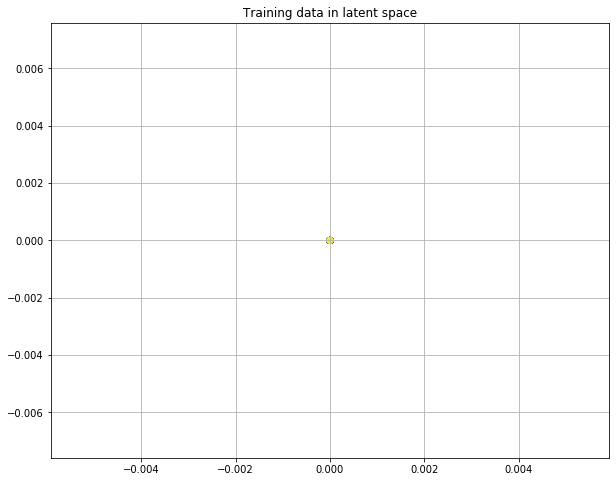

In [27]:
x = gp_x.train_targets.detach().cpu().numpy()
y = gp_y.train_targets.detach().cpu().numpy()
l = gp_x.train_inputs[0][:,4].view(-1).detach().cpu().numpy()
#print(l)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x, y, c=l, cmap='viridis')
ax.grid()
ax.set_title('Training data in latent space')

plt.show()

In [28]:
#hypers = {
#    'likelihood.noise_covar.raw_noise': torch.tensor(-0.19).to(device),
#   'covar_module.outputscale': torch.tensor(0.16).to(device),
#}

#gp_x.initialize(**hypers)

#gp_x.likelihood.noise_covar.noise = -0.19
#gp_x.covar_module.outputscale = .8

for param_name, param in gp_x.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')
    
#print(gp_x.train_inputs)

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.constant                       value = 0.0
Parameter name: covar_module.kernels.1.kernels.0.raw_outputscale value = 0.0
Parameter name: covar_module.kernels.1.kernels.0.base_kernel.raw_lengthscale value = 0.0
Parameter name: covar_module.kernels.1.kernels.0.base_kernel.c value = 1.0
Parameter name: covar_module.kernels.1.kernels.0.base_kernel.a value = 1.0
Parameter name: covar_module.kernels.1.kernels.0.base_kernel.b value = 0.0


### Saving the trained models

In [29]:
if not skip_training:
    # save the neural network
    ckpt_name = 'GPP_conv_vae_noise_MNIST.pt'
    savepath = '../../trained_models'
    torch.save(vae_model.state_dict(), os.path.join(savepath, ckpt_name))

    # save the gp models
    torch.save(gp_x.state_dict(), os.path.join(savepath, 'gp_x_flip.pth'))
    torch.save(gp_y.state_dict(), os.path.join(savepath, 'gp_y_flip.pth'))

## Label inference

We will now take observations from the training set and experiment with label inference. First we need to load in our train models, since we don't want to have to train the model again each time we restart the notebook.

### Loading the trained models

In [30]:
ckpt_name = 'GPP_conv_vae_noise_MNIST.pt'
load_path = '../../trained_models'
vae_model.load_state_dict(torch.load(os.path.join(load_path, ckpt_name)))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [31]:
vae_model.eval()

data = torch.tensor([]).to(device)
raw = torch.tensor([]).to(device)
Z = torch.tensor([]).to(device)

logvars = torch.tensor([]).to(device)
recon_data = torch.tensor([]).to(device)

for batch_idx, (data_batch, labels) in enumerate(training_loader):
        
    data_batch = data_batch.to(device)
    recon_batch, mu, logvar = vae_model(data_batch)
    #print('this is mu: {}'.format(mu))

    Z_samples = vae_model.sample_latent(mu, logvar)

    raw = torch.cat((raw, mu), dim=0)
    Z = torch.cat((Z, Z_samples), dim=0)
    logvars = torch.cat((logvars, logvar), dim=0)
    data = torch.cat((data, data_batch), dim=0)
    recon_data = torch.cat((recon_data, recon_batch), dim=0)
    #labels_during_training = torch.cat((labels_during_training, labels.to(device)), dim=0)

training_Z = Z
training_x = training_Z[:,0].view(-1)
training_y = training_Z[:,1].view(-1)

#print(training_x)

#gp_x.set_train_data(training_labels, training_x)
#gp_y.set_train_data(training_labels, training_y)

In [32]:
x_state = torch.load(os.path.join(load_path, 'gp_x_flip.pth'))
y_state = torch.load(os.path.join(load_path, 'gp_y_flip.pth'))

gp_x = ExactGPModel(training_labels, placeholder_targets, likelihood, covar_module).to(device)
gp_x.load_state_dict(x_state)

gp_y = ExactGPModel(training_labels, placeholder_targets, likelihood, covar_module).to(device)
gp_y.load_state_dict(y_state)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Preparing the test data

In [33]:
vae_model.eval()

data = torch.tensor([]).to(device)
raw = torch.tensor([]).to(device)
Z = torch.tensor([]).to(device)

logvars = torch.tensor([]).to(device)
recon_data = torch.tensor([]).to(device)
test_labels = torch.tensor([]).to(device)

for batch_idx, (data_batch, labels) in enumerate(test_loader):
        
    data_batch = data_batch.to(device)
    recon_batch, mu, logvar = vae_model(data_batch)
    #print('this is mu: {}'.format(mu))

    Z_samples = vae_model.sample_latent(mu, logvar)

    raw = torch.cat((raw, mu), dim=0)
    Z = torch.cat((Z, Z_samples), dim=0)
    logvars = torch.cat((logvars, logvar), dim=0)
    data = torch.cat((data, data_batch), dim=0)
    recon_data = torch.cat((recon_data, recon_batch), dim=0)
    test_labels = torch.cat((test_labels, labels.to(device)), dim=0)

test_Z = Z
test_x = test_Z[:,0].view(-1)
test_y = test_Z[:,1].view(-1)

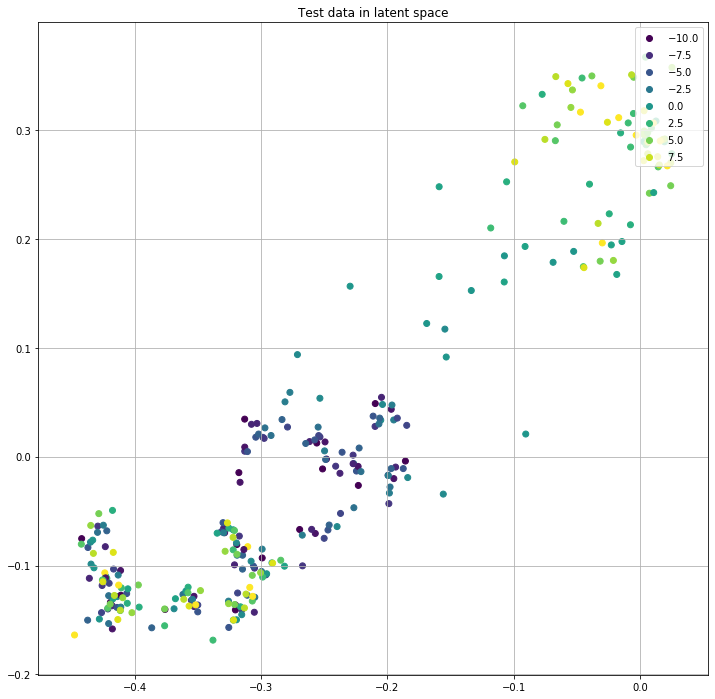

In [34]:
fig, ax = plt.subplots(figsize=(12, 12))
#ax.scatter(pred_x.mean.detach().cpu().numpy(), pred_y.mean.detach().cpu().numpy(), 
#            c=test_labels.view(-1).cpu().numpy(), cmap='viridis')
scatter = ax.scatter(test_x.detach().cpu().numpy(), test_y.detach().cpu().numpy(), 
            c=test_labels[:, 4].view(-1).detach().cpu().numpy(), cmap='viridis')
#ax.scatter(x_prime.detach().cpu().numpy(), y_prime.detach().cpu().numpy(), 
#            c='red', s=100, cmap='vididis')

ax.legend(*scatter.legend_elements(), loc="upper right")
#plt.legend()
ax.grid()
ax.set_title('Test data in latent space')
plt.show()

In [35]:
def get_test_subject(id, Z, labels):
    """
    Function for getting the latent representation and labels for a single subject.
    """
    
    indices = np.where(labels[:, 0].view(-1).detach().cpu().numpy() == id)
    x_subject = Z[indices, 0]
    y_subject = Z[indices, 1]
    labels_subject = labels[indices,:]
    
    return x_subject.view(-1), y_subject.view(-1), labels_subject[0]

In [158]:
def compute_p_sick(subject_id, test_Z, test_labels, verbose=False):
    """
    Helper function for calculating label normalized label likelihoods.
    """
    
    x_subject, y_subject, labels_subject = get_test_subject(subject_id, test_Z, test_labels)
    
    likelihoods = np.array([])
    gp_x.eval()
    gp_y.eval()
    
    true_sickness = labels_subject[0, 3].detach().cpu().numpy()
    #print(true_sickness)

    for s in [0, 1]:

        l = labels_subject.clone()
        #print(l.shape[0])
        l[:, 3] = torch.tensor(np.repeat(s, l.shape[0])).to(device)
        #print(l)

        #l = torch.tensor(l, dtype=torch.float).view(-1).to(device)
        #print(l)
        output_x, output_y = gp_x(l), gp_y(l)

        mll = mll_x(output_x, x_subject) + mll_y(output_y, y_subject)

        mll_likelihood = torch.exp(mll).cpu().detach().numpy()

        #print(f'likelihood of {s} given by mll: {true_likelihood}')

        likelihoods = np.append(likelihoods, mll_likelihood)
        #likelihoods = np.append(likelihoods, pdf_thing)

    # normalize
    probs = likelihoods / np.sum(likelihoods)
    #mll_likelihoods = mll_likelihoods / np.sum(mll_likelihoods)
    
    if verbose:
        string = 'Not sick mll: {:.3f} \t sick mll: {:.3f} \t true value: {}'.format(probs[0], 
                                                                                                  probs[1], true_sickness)
        print(string)
    return probs

In [159]:
subject_id = 4

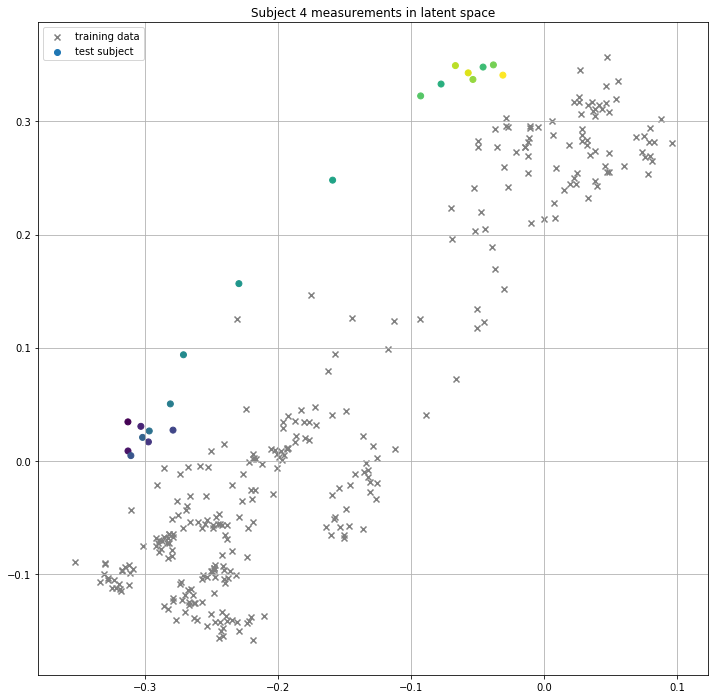

In [160]:
x_subject, y_subject, labels_subject = get_test_subject(subject_id, test_Z, test_labels)

fig, ax = plt.subplots(figsize=(12, 12))
#ax.scatter(pred_x.mean.detach().cpu().numpy(), pred_y.mean.detach().cpu().numpy(), 
#            c=test_labels.view(-1).cpu().numpy(), cmap='viridis')
ax.scatter(training_x.detach().cpu().numpy(), training_y.detach().cpu().numpy(), color='gray', 
           marker='x', label='training data')
ax.scatter(x_subject.detach().cpu().numpy(), y_subject.detach().cpu().numpy(), 
            c=labels_subject[:, 4].view(-1).detach().cpu().numpy(), cmap='viridis', label='test subject')

#ax.legend(*scatter.legend_elements(), loc="upper right")
plt.legend()
ax.grid()
ax.set_title(f'Subject {subject_id} measurements in latent space')
plt.show()

In [161]:
# test the prob function on single subject
probs = compute_p_sick(subject_id, test_Z, test_labels, verbose=True)

Not sick mll: 0.838 	 sick mll: 0.162 	 true value: 1.0


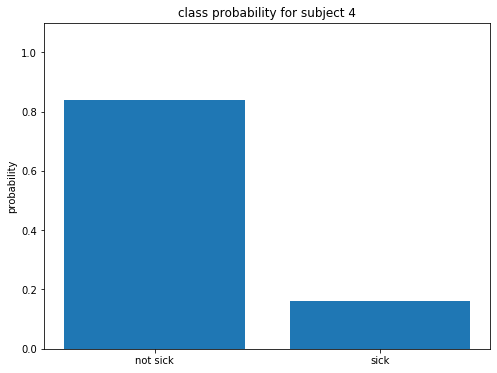

In [162]:
# draw bar plot of probabilities for single subject
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar([0,1], probs)
ax.set_title(f'class probability for subject {subject_id}')
ax.set_ylabel('probability')
ax.set_ylim(top=1.1)
plt.xticks([0,1], ('not sick', 'sick'))
plt.show()

In [163]:
# calculate label probabilities for all test subjects
for i in range(15):
    probs = compute_p_sick(i, test_Z, test_labels, verbose=True)

Not sick mll: 0.098 	 sick mll: 0.902 	 true value: 0.0
Not sick mll: 0.057 	 sick mll: 0.943 	 true value: 0.0
Not sick mll: 0.029 	 sick mll: 0.971 	 true value: 0.0
Not sick mll: 0.613 	 sick mll: 0.387 	 true value: 1.0
Not sick mll: 0.838 	 sick mll: 0.162 	 true value: 1.0
Not sick mll: 0.006 	 sick mll: 0.994 	 true value: 0.0
Not sick mll: 0.486 	 sick mll: 0.514 	 true value: 1.0
Not sick mll: 0.916 	 sick mll: 0.084 	 true value: 1.0
Not sick mll: 0.000 	 sick mll: 1.000 	 true value: 0.0
Not sick mll: 0.974 	 sick mll: 0.026 	 true value: 1.0
Not sick mll: 0.965 	 sick mll: 0.035 	 true value: 1.0
Not sick mll: 0.000 	 sick mll: 1.000 	 true value: 0.0
Not sick mll: 0.000 	 sick mll: 1.000 	 true value: 0.0
Not sick mll: 0.999 	 sick mll: 0.001 	 true value: 1.0
Not sick mll: 0.996 	 sick mll: 0.004 	 true value: 1.0
